# Bifurcation and phase plane analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import packages
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits import mplot3d

from scipy.integrate import odeint
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from numpy.linalg import norm


## The Morris-Lecar Model 

<img src="Imgs/morris-lecar.png" alt="terms" width="900"/>

In [3]:
# # Morris-Lecar parameters near SNLC
# phi = 0.067
# g_Ca = 4
# V3 = 12
# V4 = 17.4
# E_Ca = 120
# E_K = -84
# E_L = -60
# g_K = 8
# g_L = 2
# V1 = -1.2
# V2 = 18
# C_M = 20

# Morris Lecar parameters near Hopf
phi = 0.04
g_Ca = 4.4
V3 = 2
V4 = 30
E_Ca = 120
E_K = -84
E_L = -60
g_K = 8
g_L = 2
V1 = -1.2
V2 = 18
C_M = 20

# ionic gates
def m_inf(V): return 0.5*(1.+np.tanh((V-V1)/V2))
def tau_n(V): return 1./np.cosh((V-V3)/(2*V4))
def n_inf(V): return 0.5*(1.+np.tanh((V-V3)/V4))
    
# ionic currents
def I_leak(V): return g_L*(V-E_L)
def I_K(V,n): return g_K*n*(V-E_K)
def I_Ca(V): return g_Ca*m_inf(V)*(V-E_Ca)

# individual derivatives
def DV(V,n,I_ext=0):
    return (I_ext-I_leak(V)-I_K(V,n)-I_Ca(V))/C_M

def Dn(V,n):
    return phi*(n_inf(V)-n)/tau_n(V)

# neuron dynamics
def MLneuronVF(X,t,I_ext=0):
    V,n = X
    dV = DV(V,n,I_ext=I_ext)
    dn = Dn(V,n)
    return dV,dn


## Neural Dynamics

In [19]:
%matplotlib inline

# integration parameters
t_span = np.arange(0.0, 400.0, 0.1) 
I_ext = 100 # external current
X0 = [-0, 0.25] # initial condition[V0,n0]

# call ode solver
X = odeint(lambda X,t: MLneuronVF(X,t,I_ext=I_ext), X0, t_span)

colors=['tab:cyan', 'tab:pink', 'tab:olive']
def slider_plot(slider):
    slider = int(slider)
    # plot
    plt.figure(figsize=(15,8));
    # Voltage
    axV = plt.subplot(2,2,1);
    axV.plot(t_span[:slider],X[:slider,0],colors[0]);
    axV.plot(t_span[slider-1],X[slider-1,0],'ro');
    axV.set_title('V');
    axV.set_ylabel('mV');
    plt.xlim([0,t_span[-1]]);
    plt.setp(axV.get_xticklabels(), visible=False);

    # n
    axn = plt.subplot(2,2,3,sharex=axV);
    axn.plot(t_span[:slider],X[:slider,1],colors[1]);
    axn.plot(t_span[slider-1],X[slider-1,1],'ro');
    axn.set_title('n');
    axn.set_ylabel('gate value');
    axn.set_xlabel('time (ms)');
    plt.xlim([0,t_span[-1]]);

    # V,n orbit
    axP = plt.subplot(2,2,(2,4));
    axP.plot(X[:slider,0],X[:slider,1],colors[2]);
    axP.plot(X[slider,0],X[slider,1],'ro');
    axP.set_xlabel('V');
    axP.set_ylabel('n');
    
    plt.title('Morris Lecar phase plane for I_ext=%.1f' %I_ext);
    
interact(slider_plot, slider = widgets.FloatSlider(value=0,
                                               min=1,
                                               max=len(t_span)-1,
                                               step=100));

interactive(children=(FloatSlider(value=1.0, description='slider', max=3999.0, min=1.0, step=100.0), Output())…

## Nullclines

In [15]:
# function to find nullclines
from scipy.optimize import broyden1

def FindNullCline(func,x_range,xin=0):
    """Find zero of func(y(x),x) for a range of x"""
    y_range = np.empty(len(x_range))
    for i,x in enumerate(x_range):
        y_range[i] = broyden1(lambda y: func(x,y),xin=xin,f_tol=1e-14)
    return y_range

<IPython.core.display.Javascript object>


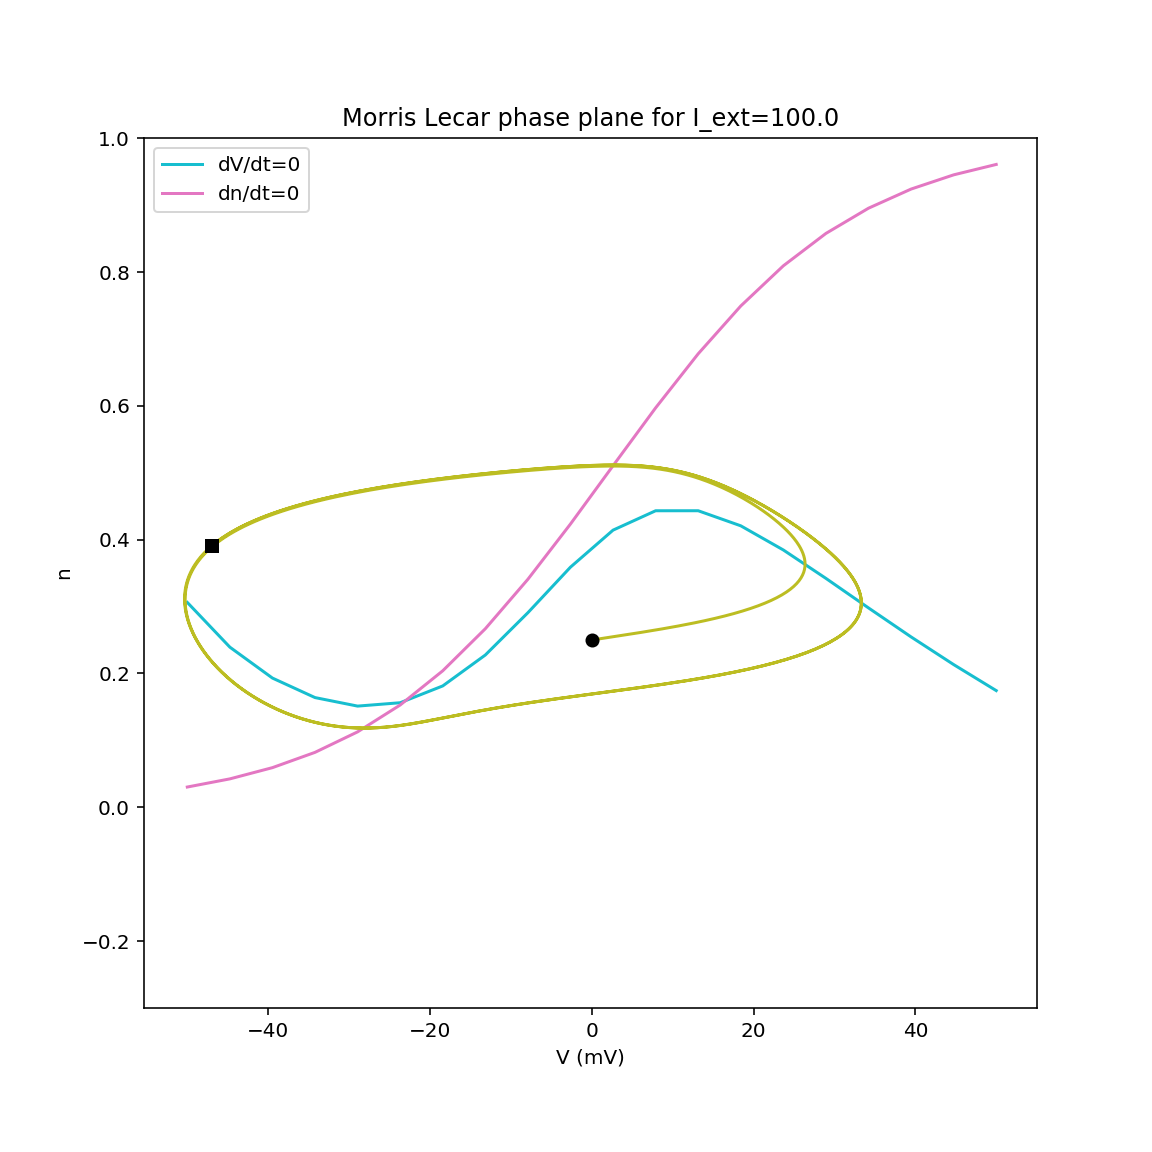

In [20]:
# plot a trajectory and nullclines for chosen param
%matplotlib notebook

# find nullclines
V_range = np.linspace(-50,50,20)
V_null_n = FindNullCline(lambda V,n:DV(V,n,I_ext=I_ext),V_range)
n_null_n = FindNullCline(Dn,V_range)

# integrate one trajetory
t_span = np.arange(0.0, 200.0, 0.1) 
# I_ext = 20
# X0 = [0, 0.25] # initial condition[V0,n0]
X = odeint(lambda X,t: MLneuronVF(X,t,I_ext=I_ext), X0, t_span)

# plot
colors=['tab:cyan', 'tab:pink', 'tab:olive']
plt.figure(figsize=(8,8));
plt.plot(V_range,V_null_n,colors[0]);
plt.plot(V_range,n_null_n,colors[1]);
plt.plot(X[:,0],X[:,1],colors[2]);
plt.plot(X[-1,0],X[-1,1],'sk');
plt.plot(X[0,0],X[0,1],'ok');
plt.ylim([-0.3,1.0]);
plt.xlabel('V (mV)');
plt.ylabel('n');
plt.legend(['dV/dt=0','dn/dt=0']);
plt.title('Morris Lecar phase plane for I_ext=%.1f' %I_ext);